In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

from data_util import *

from data_generator import DataGenerator

import model as model_util

from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.layers import InputLayer, BatchNormalization, GlobalMaxPool1D, Bidirectional, Dense, Flatten, Conv2D, LeakyReLU, Dropout, LSTM, GRU, Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras import datasets, layers, models

import tensorflow as tf
import tensorflow.keras as keras
import autokeras as ak
import kerastuner


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from keras.wrappers.scikit_learn import KerasClassifier

from numpy import array
import numpy as np



In [2]:
def reset_seed():
    seed_value= 100
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

reset_seed()

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

path = "./data/"
model_path = path + "stock.h5"

In [3]:
trainX_raw, trainY_raw = load_data("btceur", "train", path)
valX_raw, valY_raw = load_data("btceur", "Val", path)

trainX_balanced, trainY_balanced = get_balanced_set(trainX_raw, trainY_raw)

valX, valY = valX_raw, valY_raw

normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(trainX_raw)


print("{} {} | {} {}".format(trainX_balanced.shape, trainY_balanced.shape, valX.shape, valY.shape))

print("{} | {} | {}".format(Counter(trainY_raw), Counter(trainY_balanced), Counter(valY)))


features = trainX_raw.shape[-1]

(39066, 26) (39066,) | (3683, 26) (3683,)
Counter({0: 19533, 1: 1971}) | Counter({0: 19533, 1: 19533}) | Counter({0: 3317, 1: 366})


In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier

from sklearn import linear_model

def show_feature_importances(tree):
    title = 'Feature Importance:'
    figsize = (15, 5)

    feat_imp = pd.DataFrame({'Importance':tree.feature_importances_})    
    feat_imp['feature'] = [i for i in range(features[-1])]
    feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
    feat_imp = feat_imp

    feat_imp.sort_values(by='Importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
def show_confusion_matrix(tree, trainX, trainY):
    tree.fit(trainX, trainY)
    print(f'Train Accuracy: {tree.score(trainX, trainY)}')
    print(f'Val Accuracy: {tree.score(valX, valY)}')
    y_pred = tree.predict(valX)
    print(confusion_matrix(valY, y_pred))
    print(f1_score(valY, y_pred))

def eval_tree(tree, trainX, trainY, valX, valY):
    print(tree)

    param_grid = [
        {'n_estimators': [10,40, 50, 60, 100],
        'max_depth': [4, 5, 6, 10],
        'max_features': [4,6,8,10]
        }
    ]
    grid_search = GridSearchCV(tree, param_grid, cv = 5, scoring = 'accuracy', verbose = 1)
    grid_search.fit(trainX, trainY)
    
    show_confusion_matrix(tree, trainX, trainY)
    show_feature_importances(tree)
    
    

estimators = 300

BATCH_SIZE = 32

tress = [
        RandomForestClassifier(random_state=5)
        ,DecisionTreeClassifier(min_samples_leaf=600)
        ,ExtraTreesClassifier(n_estimators=estimators)
        ,GradientBoostingClassifier(n_estimators=estimators, learning_rate=1.0,  max_depth=1000, random_state=0)
        ,GaussianNB()
        ,linear_model.Ridge(alpha=.5)
        ,RidgeClassifier(alpha=.5)
        ,AdaBoostClassifier(n_estimators=estimators)
        ]


In [5]:
### GridSearchCV
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from keras.wrappers.scikit_learn import KerasClassifier
import eli5
from eli5.sklearn import PermutationImportance


def get_model_test(features = features, 
              layers = 1, 
              units = 5, 
              optimizer="Adam",
              init='glorot_uniform',
              normalizer = normalizer):
    
    reset_seed()
    inputX = Input(shape=features)
    
    x = normalizer(inputX)
    #x = inputX
    
    for lay in range(int(layers)):
        x = Dense(units, kernel_initializer=init, activation='relu')(x)
        
    x = Dropout(0.5)(x)
    
    x = Dense(10, kernel_initializer=init, activation='relu')(x)
    
    x = Dense(1, kernel_initializer=init, activation='sigmoid')(x)

    model = Model(inputs=[inputX], outputs=x)
    
    model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=METRICS)
    
    return model


norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(trainX_balanced)

params = dict(
      optimizer="Nadam", 
      layers = 6,
      units = 60,
      features = features,
      init='glorot_uniform',
      normalizer = norm
  )

my_model = KerasClassifier(build_fn=get_model_test, 
                           verbose=0, 
                           callbacks=[tf.keras.callbacks.EarlyStopping(
                                #monitor='val_precision', 
                                monitor='val_accuracy', 
                                verbose=1,
                                patience=30,
                                mode='max',
                                restore_best_weights=True)],
                           epochs=100,
                           **params,
                    validation_data=(valX, valY))

my_model.fit(trainX_balanced, trainY_balanced)



Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping


In [6]:
perm = PermutationImportance(my_model, random_state=10).fit(trainX_balanced, trainY_balanced)

In [7]:
arr = [ "Col: {}".format(i) for i in range(features)]
list = arr
eli5.show_weights(perm, feature_names = list)

Weight,Feature
0.2648 ± 0.0024,Col: 18
0.2411 ± 0.0053,Col: 10
0.2376 ± 0.0031,Col: 24
0.2343 ± 0.0037,Col: 9
0.2260 ± 0.0016,Col: 17
0.2245 ± 0.0028,Col: 7
0.2225 ± 0.0013,Col: 4
0.2157 ± 0.0028,Col: 5
0.2154 ± 0.0013,Col: 21
0.2059 ± 0.0036,Col: 12


In [8]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    my_model, 
    trainX_balanced, 
    trainY_balanced, 
    n_repeats=5, 
    random_state=10)


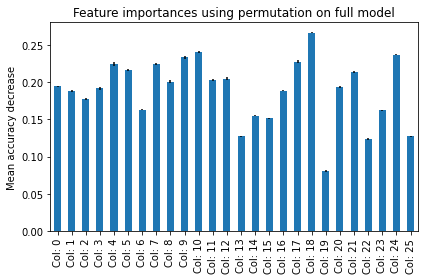

In [9]:
forest_importances = pd.Series(result.importances_mean, index=arr)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [10]:
print(result.importances_mean.argsort())

[19 22 13 25 15 14 23  6  2  1 16  3 20  0  8 11 12 21  5  4  7 17  9 24
 10 18]


In [11]:
def test_remove(col):
    remove = result.importances_mean.argsort()[:col]
    removed = np.delete(trainX_balanced , remove, 1)
    removed_val = np.delete(valX , remove, 1)
    
    norm = tf.keras.layers.experimental.preprocessing.Normalization()
    norm.adapt(removed)

    params = dict(
          optimizer="Nadam", 
          layers = 6,
          units = 60,
          features = removed.shape[-1],
          init='glorot_uniform',
          normalizer = norm
      )

    callbacks=[tf.keras.callbacks.EarlyStopping(
                                    #monitor='val_precision', 
                                    monitor='val_prc', 
                                    verbose=0,
                                    patience=30,
                                    mode='max',
                                    restore_best_weights=True)]
    
    model_tmp = KerasClassifier(build_fn=get_model_test, 
                               verbose=0, 
                               callbacks=callbacks,
                               epochs=100,
                               **params,
                        validation_data=(removed_val, valY))


    #print("{} {}".format(removed.shape, removed[index]))

    model_tmp.fit(removed, trainY_balanced)
    print(model_tmp.score(removed, trainY_balanced))


In [12]:
#print(my_model.score(trainX_balanced, trainY_balanced))

for i in range(features):
    print("Testing: {}".format(i))
    test_remove(i)


Testing: 0
0.6397122740745544
Testing: 1
0.7078021764755249
Testing: 2
0.7106178998947144
Testing: 3
0.6338248252868652
Testing: 4
0.7048072218894958
Testing: 5
0.7164030075073242
Testing: 6
0.6437823176383972
Testing: 7
0.6440638899803162
Testing: 8
0.7207034230232239
Testing: 9
0.6353350877761841
Testing: 10
0.6394819021224976
Testing: 11
0.6476987600326538
Testing: 12
0.7246454954147339
Testing: 13
0.642246425151825
Testing: 14
0.6412481665611267
Testing: 15
0.6452670097351074
Testing: 16
0.6300363540649414
Testing: 17
0.6901653409004211
Testing: 18
0.6639789342880249
Testing: 19
0.6241489052772522
Testing: 20
0.6193621158599854
Testing: 21
0.6192085146903992
Testing: 22
0.6518712043762207
Testing: 23
0.8433164358139038
Testing: 24
0.6970767378807068
Testing: 25
0.5339937806129456


In [13]:
def show_metric(history, metric): 
    plt.plot(history.history[metric])
    plt.plot(history.history["val_{}".format(metric)])
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#show_metric(history, "loss")
#show_metric(history, "precision")

In [14]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
plot_metrics(history)

NameError: name 'history' is not defined

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('True Positives: ', cm[1][1])

    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:


baseline_results = model.evaluate(valX, valY, verbose=1)


for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)



In [ ]:
plot_cm(valY, model.predict(valX))
print(test_predictions_baseline.shape)

In [ ]:
#Model 

from tensorflow.keras.layers import InputLayer, BatchNormalization, GlobalMaxPool1D, Bidirectional, Dense, Flatten, Conv2D, LeakyReLU, Dropout, LSTM, GRU, Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras import datasets, layers, models

import tensorflow as tf
#import tensorflow_addons as tfa
 
#Model 

dim = 100

def add_deep_layers(x, dropout, units):
    #x = Dropout(0.2)(x)
    x = Dense(units, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(units, activation='relu')(x)
    return x

def get_model(features, layers, units):
    reset_seed()
    inputX = Input(shape=features)
    
    x = normalizer(inputX)
    
    for lay in range(int(layers)):
        x = add_deep_layers(x, 0.2, units)
    
    x = Dense(10, activation='relu')(x)
    
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inputX], outputs=x)
    
    return model


def generate_model_rnn(seqs, features, units, dropout, lays, lays_seq):
    inputX = Input(shape=(seqs, features))
    
    x = inputX
    x = normalizer(inputX)
    
    for lay in range(int(lays_seq)):
        x = LSTM(units=units, return_sequences=True)(x)
    
    #x = Bidirectional(LSTM(dim, return_sequences=False))(x)
    x = LSTM(dim, return_sequences=False)(x)
    
    for lay in range(int(lays)):
        x = add_deep_layers(x, dropout, units)
        
    x = Dense(20, activation='relu')(x)
    
    x = Dense(1, activation='sigmoid')(x)

    return Model(inputs=[inputX], outputs=x)


def compile_model(model):
    model.compile(
        #optimizer=ranger,
        optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.00001, rho=0.95, epsilon=1e-07),
        #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=METRICS
    )

path = "./data/"


In [ ]:


#model = load_model(filepath = "drive/My Drive/model/stock.h5")

#!rm "drive/My Drive/model/encoder.h5"

def get_simple():
    model = Sequential()
    reset_seed()
    model.add(InputLayer(input_shape=features))
    model.add(normalizer)
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model



def autokeras_class(max_trials = 30):
    clf = ak.StructuredDataClassifier(overwrite=True, 
                                  max_trials=max_trials,
                                  metrics=METRICS,
                                  objective=kerastuner.Objective("val_prc", direction="max"),
                                  project_name = "AutoKeras",
                                  #tuner='random',
                                 )
    return clf

def autokeras_time_class(max_trials = 30):
    predict_from = 1
    predict_until = 10
    lookback = 0

    return ak.TimeseriesForecaster(
                              max_trials=max_trials,
                              metrics=METRICS,
                                  objective=kerastuner.Objective("val_prc", direction="max"),
                              project_name = "AutoKeras Time",
                              #tuner='random',
                             )


In [ ]:
model = clf.export_model()
model.summary()

In [ ]:
max = 40
a = [[i, i] for i in range(max)]


def gen_y(i):
    if (i > 35):
        return 1
    else:
        return 0

b = [gen_y(i) for i in range(max)]

In [ ]:
xx, yy = create_dataset(a, b, time_steps=3, null_value = 0)

print(xx.shape)
print(yy.shape)

counter = Counter(yy)
print("{} - {}".format(counter, (counter[0] - counter[1])))

x_balanced, y_balanced = get_balanced_set_seq(xx, yy)

print(x_balanced.shape)
print(y_balanced.shape)

counter = Counter(y_balanced)
print("{} - {}".format(counter, (counter[0] - counter[1])))

In [ ]:
#print(x_balanced) 

index = -4
#print(x_balanced[index][-1][-1]) 
#print(y_balanced[index])

for i in range(len(x_balanced)):
    xx = x_balanced[i][-1][-1]
    if (xx < 35):
        print("{}) {} - {}".format(i, xx, y_balanced[i]))


In [ ]:
print(trainX.shape)
print(trainY.shape)

x_, y_ = create_dataset(trainX, trainY, time_steps=20, null_value = 0)

print(x_.shape)
print(y_.shape)

counter = Counter(y_)
print("{} - {}".format(counter, (counter[0] - counter[1])))

x_balanced, y_balanced = get_balanced_set_seq(x_, y_)

print(x_balanced.shape)
print(y_balanced.shape)

counter = Counter(y_balanced)
print("{} - {}".format(counter, (counter[0] - counter[1])))

In [ ]:
[i for i in range(6)]